In [11]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import shap
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.metrics import mean_absolute_error
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam

In [2]:
#Read in data into a dataframe
df = pd.read_csv("ICP_data.csv")

In [3]:
#Separate the features and targets into separate dfs
X = df.drop(['Tensile Modulus', 'Flexural Modulus',
             'Impact Strength'], axis = 1)
y = df[['Tensile Modulus', 'Flexural Modulus',
       'Impact Strength']]
X.columns, y.columns

(Index(['C2', 'R21', 'RCC2', 'MFR'], dtype='object'),
 Index(['Tensile Modulus', 'Flexural Modulus', 'Impact Strength'], dtype='object'))

In [4]:
def visualize_beeswarm(df, structural_columns):
    """
    Visualize the spread of structural properties using a beeswarm plot.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        structural_columns (list): List of column names corresponding to structural properties.
    """
    plt.figure(figsize=(5, 3))
    ax = sns.swarmplot(data=df[structural_columns], orient='h', palette=None, size=2, dodge=False)
    # Accessing points to adjust alpha
    for collection in ax.collections:
        collection.set_alpha(1)
    
    
    # Add space by adjusting y-axis limits
    current_limits = ax.get_ylim()
    new_limits = (current_limits[0] + 0.5, current_limits[1] - 0.5)  # Adds 0.5 padding on both sides
    ax.set_ylim(new_limits)
    
    # Set labels and title
    plt.title('Distribution of\nStructural Properties', fontsize = 14)
    plt.xlabel('Value', fontsize = 14)
    plt.ylabel('Structural\nProperties', fontsize = 14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

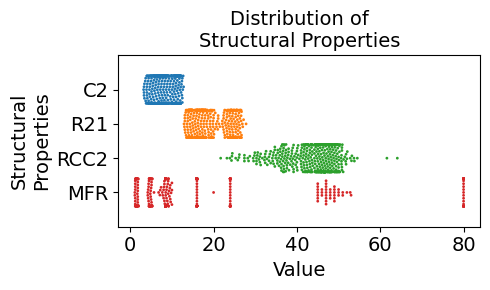

In [5]:
#Plot spread of data
visualize_beeswarm(X, X.columns)

In [6]:
#Separate target variables
y_tensile = df['Tensile Modulus']
y_flexural = df['Flexural Modulus']
y_impact = df['Impact Strength']

In [8]:
def plot_custom_correlation_matrices(df):
    """
    Plots two correlation matrices:
    1. Correlation matrix for 'C2', 'R21', 'RCC2', 'MFR'.
    2. Correlation matrix for 'C2', 'R21', 'RCC2', 'MFR' vs 'Tensile Modulus', 'Flexural Modulus', 'Impact Strength'.
    
    Parameters:
    - df: Pandas DataFrame containing all the required columns.
    """
    # Define the groups of columns
    group1 = ['C2', 'R21', 'RCC2', 'MFR']
    group2 = ['Tensile Modulus', 'Flexural Modulus', 'Impact Strength']
    
    # Subset for group1 correlation matrix
    corr_group1 = df[group1].corr()
    plt.figure(figsize=(5, 2))
    sns.heatmap(corr_group1, annot=True, cmap='coolwarm', cbar = False, fmt='.2f', linewidths=0.8, annot_kws={"size": 14, "weight":"bold"})
    plt.title('Correlation between features', fontsize = 14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14, rotation = 0.0)
    plt.show()
    
    # Subset for group1 vs group2 correlation matrix
    corr_group1_vs_group2 = pd.DataFrame({
        feature: [df[feature].corr(df[target]) for target in group2]
        for feature in group1
    }, index=group2).T
    
    plt.figure(figsize=(5, 2))
    plt.title('Correlation between\nfeatures and targets', fontsize = 14)
    ax = sns.heatmap(corr_group1_vs_group2, annot=True, cmap='coolwarm', cbar=False, fmt='.2f', linewidths=0.8, annot_kws={"size": 14, "weight":"bold"})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14, rotation = 0.0)
    ax.set_xticklabels(['Tensile\nModulus', 'Flexural\nModulus', 'Impact\nStrength'])
    plt.show()

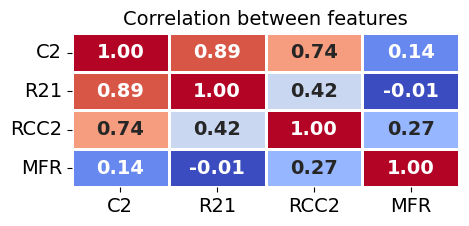

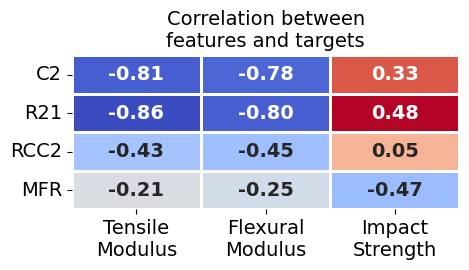

In [9]:
plot_custom_correlation_matrices(df)

In [30]:
lr_results = {}

In [18]:
def tune_and_evaluate_linear_models(X, y, model_type="linear", physical_property = None):
    """
    Train and evaluate a Linear, Ridge, or Lasso Regression model with hyperparameter tuning.
    
    Parameters:
        X (pd.DataFrame or np.ndarray): Feature matrix.
        y (pd.Series or np.ndarray): Target vector.
        model_type (str): Type of model to train. Options: 'linear', 'ridge', 'lasso'.
        test_size (float): Proportion of data to be used as the test set.
        random_state (int): Random state for reproducibility.
    
    Returns:
        best_model: Trained regression model.
        best_params: Parameters of the best model.
    """
    
     # Scale the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Select the model type and define the hyperparameter grid
    if model_type == "linear":
        model = LinearRegression()
        param_grid = {}  # Linear Regression has no hyperparameters
        
        model_key = "LinearRegressor"
        if model_key not in lr_results:
            lr_results[model_key] = []
            
    elif model_type == "ridge":
        model = Ridge()
        param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}  # Regularization strength
        
        model_key = "RidgeRegressor"
        if model_key not in lr_results:
            lr_results[model_key] = []
            
    elif model_type == "lasso":
        model = Lasso()
        param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}  # Regularization strength
        
        model_key = "LassoRegressor"
        if model_key not in lr_results:
            lr_results[model_key] = []
            
    else:
        raise ValueError("Invalid model_type. Choose 'linear', 'ridge', or 'lasso'.")
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5,
                               verbose=1, n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate evaluation metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    lr_results[model_key].append(np.round(test_r2, 2))
    
    # Print evaluation metrics
    print(f"Model Type: {model_type.capitalize()} Regression")
    print(f"Best Parameters: {best_params}")
    print(f"Training MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test, y_test_pred, alpha=0.9, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')  # y=x line
    
    # Add R² and MSE to the bottom right of the plot
    plt.text(0.95, 0.05, f'R² = {test_r2:.2f}\nRMSE = {np.sqrt(test_mse):.2f}', transform=plt.gca().transAxes,
             verticalalignment='bottom', horizontalalignment='right', fontsize=15, 
             bbox=dict(facecolor='white', alpha=0.0, edgecolor=None))
    
    # Customize plot
    plt.xlabel('Actual Values', fontsize = 15)
    plt.ylabel('Predicted Values', fontsize = 15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.title(f'{physical_property}', fontsize = 14)
    plt.legend(frameon=False)  # Remove border around legend
    plt.tight_layout()
    plt.show()
    
    return best_model, best_params

Linear Regression:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Model Type: Linear Regression
Best Parameters: {}
Training MSE: 6449.3561
Test MSE: 7191.9307
Training R²: 0.8036
Test R²: 0.7341


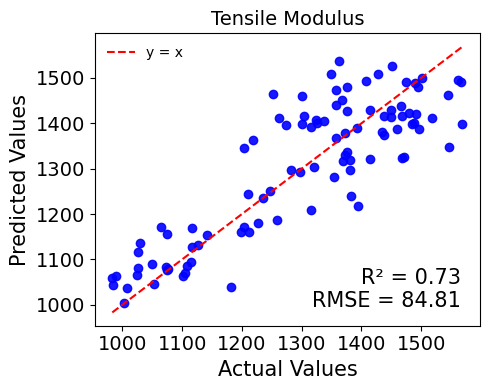

In [31]:
print("Linear Regression:")
best_model_linear_tensile, best_params_linear_tensile = tune_and_evaluate_linear_models(X,y_tensile, model_type="linear", physical_property = 'Tensile Modulus')

Linear Regression:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Model Type: Linear Regression
Best Parameters: {}
Training MSE: 8982.3824
Test MSE: 9626.4039
Training R²: 0.7284
Test R²: 0.6382


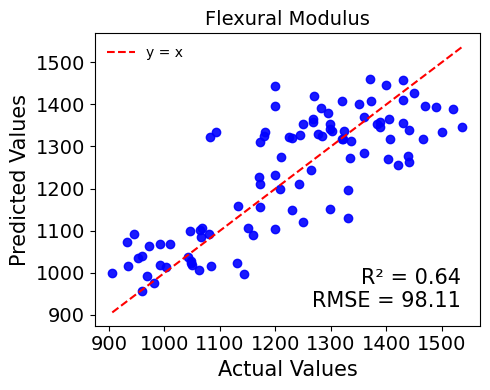

In [32]:
print("Linear Regression:")
best_model_linear_flexural, best_params_linear_flexural = tune_and_evaluate_linear_models(X, y_flexural, model_type="linear", physical_property = 'Flexural Modulus')

Linear Regression:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Model Type: Linear Regression
Best Parameters: {}
Training MSE: 350.2743
Test MSE: 379.9394
Training R²: 0.4644
Test R²: 0.3966


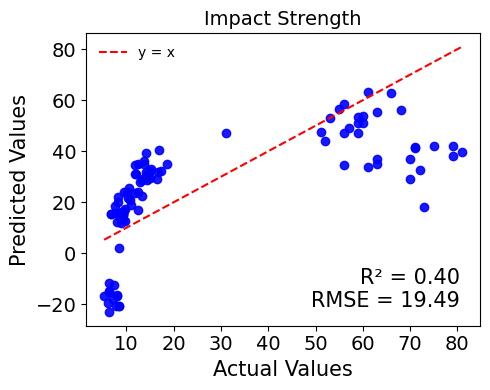

In [33]:
print("Linear Regression:")
best_model_linear_impact, best_params_linear_impact = tune_and_evaluate_linear_models(X, y_impact, model_type="linear", physical_property = 'Impact Strength')

Ridge Regression:
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Model Type: Ridge Regression
Best Parameters: {'alpha': 1}
Training MSE: 6449.3625
Test MSE: 7191.3506
Training R²: 0.8036
Test R²: 0.7341


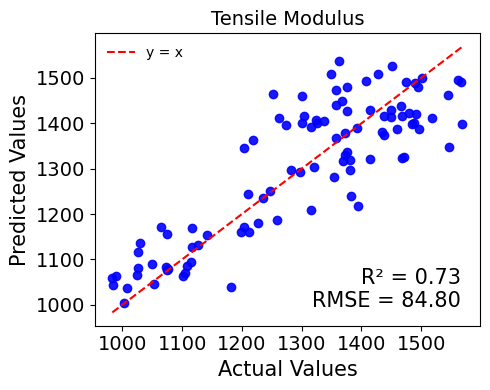

In [34]:
# Ridge Regression
print("Ridge Regression:")
best_model_ridge_tensile, best_params_ridge_tensile = tune_and_evaluate_linear_models(X, y_tensile, model_type="ridge", physical_property = 'Tensile Modulus')

Ridge Regression:
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Model Type: Ridge Regression
Best Parameters: {'alpha': 100}
Training MSE: 8987.3357
Test MSE: 9575.9028
Training R²: 0.7282
Test R²: 0.6401


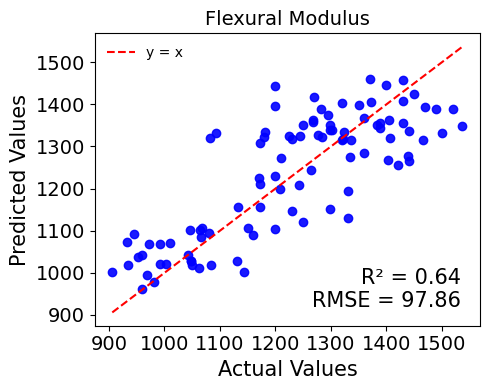

In [35]:
# Ridge Regression
print("Ridge Regression:")
best_model_ridge_flexural, best_params_ridge_flexural = tune_and_evaluate_linear_models(X, y_flexural, model_type="ridge", physical_property = "Flexural Modulus")

Ridge Regression:
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Model Type: Ridge Regression
Best Parameters: {'alpha': 1}
Training MSE: 350.2749
Test MSE: 380.0623
Training R²: 0.4644
Test R²: 0.3964


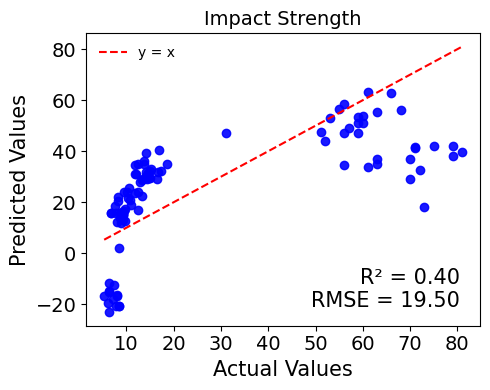

In [36]:
# Ridge Regression
print("Ridge Regression:")
best_model_ridge_impact, best_params_ridge_impact = tune_and_evaluate_linear_models(X, y_impact, model_type="ridge", physical_property = "Impact Strength")

Lasso Regression:
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Model Type: Lasso Regression
Best Parameters: {'alpha': 1}
Training MSE: 6449.4352
Test MSE: 7188.6653
Training R²: 0.8036
Test R²: 0.7342


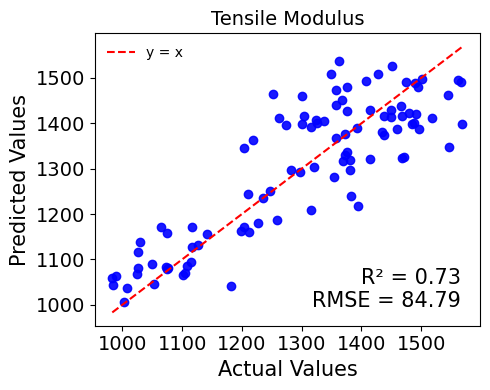

In [37]:
# Lasso Regression
print("Lasso Regression:")
best_model_lasso_tensile, best_params_lasso_tensile = tune_and_evaluate_linear_models(X, y_tensile, model_type="lasso", physical_property = "Tensile Modulus")

Lasso Regression:
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Model Type: Lasso Regression
Best Parameters: {'alpha': 1}
Training MSE: 8983.1190
Test MSE: 9639.7800
Training R²: 0.7284
Test R²: 0.6377


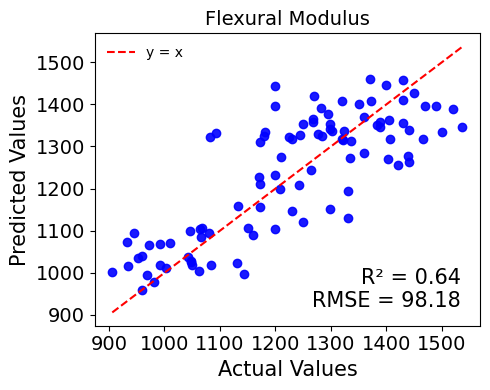

In [38]:
# Lasso Regression
print("Lasso Regression:")
best_model_lasso_flexural, best_params_lasso_flexural = tune_and_evaluate_linear_models(X, y_flexural, model_type="lasso", physical_property = "Flexural Modulus")

Lasso Regression:
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Model Type: Lasso Regression
Best Parameters: {'alpha': 0.01}
Training MSE: 350.2753
Test MSE: 380.0854
Training R²: 0.4644
Test R²: 0.3963


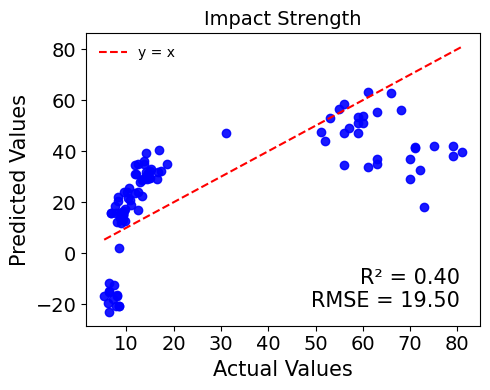

In [39]:
# Lasso Regression
print("Lasso Regression:")
best_model_lasso_impact, best_params_lasso_impact = tune_and_evaluate_linear_models(X, y_impact, model_type="lasso", physical_property = "Impact Strength")

In [40]:
lr_results

{'LinearRegressor': [0.73, 0.64, 0.4],
 'RidgeRegressor': [0.73, 0.64, 0.4],
 'LassoRegressor': [0.73, 0.64, 0.4]}

In [10]:
results = {}

In [ ]:
def tune_rf_model(X, y, rf_model=None, param_grid=None, test_size=0.2, random_state=42, physical_property = None):
    """
    Tune a Random Forest model with GridSearchCV, scale the input data, visualize training and validation loss,
    and output the best parameters.
    
    Parameters:
    - X: Features (Input variables)
    - y: Target variable
    - rf_model: A RandomForestRegressor model (optional)
    - param_grid: Hyperparameter grid for tuning (optional)
    - test_size: Fraction of the data to use for testing (default: 0.2)
    - random_state: Seed for reproducibility (default: 42)
    
    Returns:
    - best_model: The trained Random Forest model with the best parameters
    - best_params: The best hyperparameters found by GridSearchCV
    """
    
    # Use a default Random Forest model if none is provided
    if rf_model is None:
        rf_model = RandomForestRegressor(random_state=random_state)
        
    model_key = "All features"
    if model_key not in results:
        results[model_key] = []
    
    
    # Define a default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100, 200, 250, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
   
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', 
                               cv=5, verbose=1, n_jobs=-1, return_train_score=True)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    
    # Retrieve the best parameters and the best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    

    print(f'Best params: {best_params}')
    print(f'Best Model: {best_model}')
    
    # Predict on the training and testing sets
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    # Calculate the training and validation loss (MSE)
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    results[model_key].append(np.round(test_r2, 2))
    
    print(f'Train MSE = {train_mse}')
    print(f'Test MSE = {test_mse}')
    print(f'Train R2 = {train_r2}')
    print(f'Test R2 = {test_r2}')
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test, test_preds, alpha=0.9, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')  # y=x line
    
    # Add R² and MSE to the bottom right of the plot
    plt.text(0.95, 0.05, f'R² = {test_r2:.2f}\nRMSE = {np.sqrt(test_mse):.2f}', transform=plt.gca().transAxes,
             verticalalignment='bottom', horizontalalignment='right', fontsize=15, 
             bbox=dict(facecolor='white', alpha=0.0, edgecolor=None))
    
    # Customize plot
    plt.xlabel('Actual Values', fontsize = 15)
    plt.ylabel('Predicted Values', fontsize = 15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.title(f'{physical_property}', fontsize = 14)
    plt.legend(frameon=False)  # Remove border around legend
    plt.tight_layout()
    plt.show()
    
     #Create the SHAP explainer and calculate SHAP values
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # SHAP summary plot (beeswarm plot)
    shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_size=(5, 3))
    
    # Feature importance
    feature_importances = best_model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

    # Plot feature importance as a normal bar plot
    plt.figure(figsize=(4, 3))
    bars = plt.bar(feature_importance_df["Feature"], feature_importance_df["Importance"], color="blue")

    # Add the importance values inside the bars
    for bar in bars:
        yval = bar.get_height()  # Get the height of the bar (importance value)
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate: Center of the bar
            yval - 0.01,  # Y-coordinate: Slightly below the top of the bar
            f"{yval:.2f}",  # Format the value to 2 decimal places
            ha="center",  # Horizontal alignment
            va="top",  # Vertical alignment
            color="white",  # Text color
            fontsize=12,  # Font size
            weight="bold"  # Bold font
        )
    plt.xlabel("Structual Properties", fontsize=14)
    plt.ylabel("Relative Importance", fontsize=14)
    plt.title(f'{physical_property}', fontsize=14)
    plt.xticks(fontsize=14)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=14)
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()
    
    return best_model, best_params

In [ ]:
best_rf_model_tensile0, best_rf_tensile_params0 = tune_rf_model(X, y_tensile, physical_property = "Tensile Modulus")

In [ ]:
best_rf_model_flexural0, best_rf_flexural_params0 = tune_rf_model(X, y_flexural, physical_property = "Flexural Modulus")

In [ ]:
best_rf_model_impact0, best_rf_impact_params0 = tune_rf_model(X, y_impact, physical_property = "Impact Strength")

In [ ]:
def learning_curve_rf_model(X, y, rf_model=None, param_grid=None, test_size=0.2, random_state=42, physical_property=None):
    if rf_model is None:
        rf_model = RandomForestRegressor(random_state=random_state)
        
    if param_grid is None:
        param_grid = {
            'n_estimators': [1, 5, 10, 15, 20, 30, 50, 100, 150, 200, 250, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                               scoring='neg_root_mean_squared_error',
                               cv=5, verbose=1, n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Extract RMSE data
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['mean_test_rmse'] = -cv_results['mean_test_score']
    cv_results['mean_train_rmse'] = -cv_results['mean_train_score']

    rmse_by_estimators = cv_results.groupby('param_n_estimators')[['mean_train_rmse', 'mean_test_rmse']].mean().reset_index()

    # Plot RMSE vs. n_estimators
    plt.figure(figsize=(6, 4))
    plt.plot(rmse_by_estimators['param_n_estimators'], rmse_by_estimators['mean_train_rmse'],
             marker='o', color='blue', label='Training RMSE')
    plt.plot(rmse_by_estimators['param_n_estimators'], rmse_by_estimators['mean_test_rmse'],
             marker='o', color='red', label='Validation RMSE')
    plt.title(f'Learning curve: {physical_property}', fontsize=14)
    plt.xlabel('Number of Estimators', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.legend(fontsize=14, frameon = False)
    plt.tight_layout()
    plt.show()

    # Print final model metrics
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    print(f'Train R2 = {train_r2:.3f}, Test R2 = {test_r2:.3f}')
    print(f'Train RMSE = {np.sqrt(train_mse):.2f}, Test RMSE = {np.sqrt(test_mse):.2f}')
    print(f'{best_model}')
    print(f'{best_params}')

    return best_model, best_params, rmse_by_estimators


In [ ]:
a, b, c = learning_curve_rf_model(X, y_tensile, physical_property = "Tensile Modulus")

In [ ]:
d, e, f = learning_curve_rf_model(X, y_flexural, physical_property = "Flexural Modulus")

In [ ]:
g, h, i = learning_curve_rf_model(X, y_impact, physical_property = "Impact Strength")

In [ ]:
def tune_rf_model_withoutC2(X, y, rf_model=None, param_grid=None, test_size=0.2, random_state=42, physical_property = None):
    """
    Tune a Random Forest model with GridSearchCV, scale the input data without C2, visualize training and validation loss,
    and output the best parameters.
    
    Parameters:
    - X: Features (Input variables)
    - y: Target variable
    - rf_model: A RandomForestRegressor model (optional)
    - param_grid: Hyperparameter grid for tuning (optional)
    - test_size: Fraction of the data to use for testing (default: 0.2)
    - random_state: Seed for reproducibility (default: 42)
    
    Returns:
    - best_model: The trained Random Forest model with the best parameters
    - best_params: The best hyperparameters found by GridSearchCV
    """
    
    # Use a default Random Forest model if none is provided
    if rf_model is None:
        rf_model = RandomForestRegressor(random_state=random_state)
        
    model_key = "Without C2"
    if model_key not in results:
        results[model_key] = []
    
    
    # Define a default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100, 200, 250, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
   
    X = X.drop(['C2'], axis = 1)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', 
                               cv=5, verbose=1, n_jobs=-1, return_train_score=True)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Retrieve the best parameters and the best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print(f'Best params: {best_params}')
    print(f'Best Model: {best_model}')
    
    # Predict on the training and testing sets
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    # Calculate the training and validation loss (MSE)
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    results[model_key].append(np.round(test_r2, 2))
    
    print(f'Train MSE = {train_mse}')
    print(f'Test MSE = {test_mse}')
    print(f'Train R2 = {train_r2}')
    print(f'Test R2 = {test_r2}')
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test, test_preds, alpha=0.9, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')  # y=x line
    
    # Add R² and MSE to the bottom right of the plot
    plt.text(0.95, 0.05, f'R² = {test_r2:.2f}\nRMSE = {np.sqrt(test_mse):.2f}', transform=plt.gca().transAxes,
             verticalalignment='bottom', horizontalalignment='right', fontsize=15, 
             bbox=dict(facecolor='white', alpha=0.0, edgecolor=None))
    
    # Customize plot
    plt.xlabel('Actual Values', fontsize = 15)
    plt.ylabel('Predicted Values', fontsize = 15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.title(f'{physical_property}', fontsize = 14)
    plt.legend(frameon=False)  # Remove border around legend
    plt.tight_layout()
    plt.show()
    
     #Create the SHAP explainer and calculate SHAP values
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # SHAP summary plot (beeswarm plot)
    shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_size=(5, 3))
    
    # Feature importance
    feature_importances = best_model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

    # Plot feature importance as a normal bar plot
    plt.figure(figsize=(4, 3))
    bars = plt.bar(feature_importance_df["Feature"], feature_importance_df["Importance"], color="blue")

    # Add the importance values inside the bars
    for bar in bars:
        yval = bar.get_height()  # Get the height of the bar (importance value)
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate: Center of the bar
            yval - 0.01,  # Y-coordinate: Slightly below the top of the bar
            f"{yval:.2f}",  # Format the value to 2 decimal places
            ha="center",  # Horizontal alignment
            va="top",  # Vertical alignment
            color="white",  # Text color
            fontsize=12,  # Font size
            weight="bold"  # Bold font
        )
    plt.xlabel("Structual Properties", fontsize=14)
    plt.ylabel("Relative Importance", fontsize=14)
    plt.title(f'{physical_property}', fontsize=14)
    plt.xticks(fontsize=14)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=14)
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()
    
    return best_model, best_params

In [ ]:
best_rf_model_tensile, best_rf_tensile_params = tune_rf_model_withoutC2(X, y_tensile, physical_property = "Tensile Modulus")

In [ ]:
best_rf_model_flexural, best_rf_flexural_params = tune_rf_model_withoutC2(X, y_flexural, physical_property = 'Flexural Modulus')

In [ ]:
best_rf_model_impact, best_rf_impact_params = tune_rf_model_withoutC2(X, y_impact, physical_property = "Impact Strength")

In [ ]:
def tune_rf_model_withoutRCC2(X, y, rf_model=None, param_grid=None, test_size=0.2, random_state=42, physical_property = None):
    """
    Tune a Random Forest model with GridSearchCV, scale the input data without RCC2, visualize training and validation loss,
    and output the best parameters.
    
    Parameters:
    - X: Features (Input variables)
    - y: Target variable
    - rf_model: A RandomForestRegressor model (optional)
    - param_grid: Hyperparameter grid for tuning (optional)
    - test_size: Fraction of the data to use for testing (default: 0.2)
    - random_state: Seed for reproducibility (default: 42)
    
    Returns:
    - best_model: The trained Random Forest model with the best parameters
    - best_params: The best hyperparameters found by GridSearchCV
    """
    
    # Use a default Random Forest model if none is provided
    if rf_model is None:
        rf_model = RandomForestRegressor(random_state=random_state)
        
    model_key = "Without RCC2"
    if model_key not in results:
        results[model_key] = []
    
    
    # Define a default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100, 200, 250, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
   
    X = X.drop(['RCC2'], axis = 1)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', 
                               cv=5, verbose=1, n_jobs=-1, return_train_score=True)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Retrieve the best parameters and the best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print(f'Best params: {best_params}')
    print(f'Best Model: {best_model}')
    
    # Predict on the training and testing sets
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    # Calculate the training and validation loss (MSE)
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    results[model_key].append(np.round(test_r2, 2))
    
    print(f'Train MSE = {train_mse}')
    print(f'Test MSE = {test_mse}')
    print(f'Train R2 = {train_r2}')
    print(f'Test R2 = {test_r2}')
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test, test_preds, alpha=0.9, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')  # y=x line
    
    # Add R² and MSE to the bottom right of the plot
    plt.text(0.95, 0.05, f'R² = {test_r2:.2f}\nRMSE = {np.sqrt(test_mse):.2f}', transform=plt.gca().transAxes,
             verticalalignment='bottom', horizontalalignment='right', fontsize=15, 
             bbox=dict(facecolor='white', alpha=0.0, edgecolor=None))
    
    # Customize plot
    plt.xlabel('Actual Values', fontsize = 15)
    plt.ylabel('Predicted Values', fontsize = 15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.title(f'{physical_property}', fontsize = 14)
    plt.legend(frameon=False)  # Remove border around legend
    plt.tight_layout()
    plt.show()
    
     #Create the SHAP explainer and calculate SHAP values
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # SHAP summary plot (beeswarm plot)
    shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_size=(5, 3))
    
    # Feature importance
    feature_importances = best_model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

    # Plot feature importance as a normal bar plot
    plt.figure(figsize=(4, 3))
    bars = plt.bar(feature_importance_df["Feature"], feature_importance_df["Importance"], color="blue")

    # Add the importance values inside the bars
    for bar in bars:
        yval = bar.get_height()  # Get the height of the bar (importance value)
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate: Center of the bar
            yval - 0.01,  # Y-coordinate: Slightly below the top of the bar
            f"{yval:.2f}",  # Format the value to 2 decimal places
            ha="center",  # Horizontal alignment
            va="top",  # Vertical alignment
            color="white",  # Text color
            fontsize=12,  # Font size
            weight="bold"  # Bold font
        )
    plt.xlabel("Structual Properties", fontsize=14)
    plt.ylabel("Relative Importance", fontsize=14)
    plt.title(f'{physical_property}', fontsize=14)
    plt.xticks(fontsize=14)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=14)
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()
    
    return best_model, best_params

In [ ]:
best_rf_model_tensile1, best_rf_tensile_params1 = tune_rf_model_withoutRCC2(X, y_tensile, physical_property = "Tensile Modulus")

In [ ]:
best_rf_model_flexural1, best_rf_flexural_params1 = tune_rf_model_withoutRCC2(X, y_flexural, physical_property = "Flexural Modulus")

In [ ]:
best_rf_model_impact1, best_rf_impact_params1 = tune_rf_model_withoutRCC2(X, y_impact, physical_property = "Impact Strength")

In [ ]:
def tune_rf_model_withoutC2andRCC2(X, y, rf_model=None, param_grid=None, test_size=0.2, random_state=42, physical_property = None):
    """
    Tune a Random Forest model with GridSearchCV, scale the input data without C2 and RCC2, visualize training and validation loss,
    and output the best parameters.
    
    Parameters:
    - X: Features (Input variables)
    - y: Target variable
    - rf_model: A RandomForestRegressor model (optional)
    - param_grid: Hyperparameter grid for tuning (optional)
    - test_size: Fraction of the data to use for testing (default: 0.2)
    - random_state: Seed for reproducibility (default: 42)
    
    Returns:
    - best_model: The trained Random Forest model with the best parameters
    - best_params: The best hyperparameters found by GridSearchCV
    """
    
    # Use a default Random Forest model if none is provided
    if rf_model is None:
        rf_model = RandomForestRegressor(random_state=random_state)
        
    model_key = "Without C2 and RCC2"
    if model_key not in results:
        results[model_key] = []
    
    
    # Define a default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100, 200, 250, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }
   
    X = X.drop(['C2', 'RCC2'], axis = 1)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', 
                               cv=5, verbose=1, n_jobs=-1, return_train_score=True)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Retrieve the best parameters and the best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print(f'Best params: {best_params}')
    print(f'Best Model: {best_model}')
    
    # Predict on the training and testing sets
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    # Calculate the training and validation loss (MSE)
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    results[model_key].append(np.round(test_r2, 2))
    
    print(f'Train MSE = {train_mse}')
    print(f'Test MSE = {test_mse}')
    print(f'Train R2 = {train_r2}')
    print(f'Test R2 = {test_r2}')
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test, test_preds, alpha=0.9, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')  # y=x line
    
    # Add R² and MSE to the bottom right of the plot
    plt.text(0.95, 0.05, f'R² = {test_r2:.2f}\nRMSE = {np.sqrt(test_mse):.2f}', transform=plt.gca().transAxes,
             verticalalignment='bottom', horizontalalignment='right', fontsize=15, 
             bbox=dict(facecolor='white', alpha=0.0, edgecolor=None))
    
    # Customize plot
    plt.xlabel('Actual Values', fontsize = 15)
    plt.ylabel('Predicted Values', fontsize = 15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.title(f'{physical_property}', fontsize = 14)
    plt.legend(frameon=False)  # Remove border around legend
    plt.tight_layout()
    plt.show()
    
     #Create the SHAP explainer and calculate SHAP values
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # SHAP summary plot (beeswarm plot)
    shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_size=(5, 3))
    
    # Feature importance
    feature_importances = best_model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

    # Plot feature importance as a normal bar plot
    plt.figure(figsize=(4, 3))
    bars = plt.bar(feature_importance_df["Feature"], feature_importance_df["Importance"], color="blue")

    # Add the importance values inside the bars
    for bar in bars:
        yval = bar.get_height()  # Get the height of the bar (importance value)
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate: Center of the bar
            yval - 0.01,  # Y-coordinate: Slightly below the top of the bar
            f"{yval:.2f}",  # Format the value to 2 decimal places
            ha="center",  # Horizontal alignment
            va="top",  # Vertical alignment
            color="white",  # Text color
            fontsize=12,  # Font size
            weight="bold"  # Bold font
        )
    plt.xlabel("Structual Properties", fontsize=14)
    plt.ylabel("Relative Importance", fontsize=14)
    plt.title(f'{physical_property}', fontsize=14)
    plt.xticks(fontsize=14)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=14)
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()
    
    return best_model, best_params

In [ ]:
best_rf_model_tensile2, best_rf_tensile_params2 = tune_rf_model_withoutC2andRCC2(X, y_tensile, physical_property = "Tensile Modulus")

In [ ]:
best_rf_model_flexural2, best_rf_flexural_params2 = tune_rf_model_withoutC2andRCC2(X, y_flexural, physical_property = "Flexural Modulus")

In [ ]:
best_rf_model_impact2, best_rf_impact_params2 = tune_rf_model_withoutC2andRCC2(X, y_impact, physical_property = "Impact Strength")

In [ ]:
column_headings = ['Tensile Modulus', 'Flexural Modulus', 'Impact Strength']
results_df = pd.DataFrame(results, index = column_headings)
results_df.T

In [ ]:
def tune_neural_network(X, y, physical_property = None):
    # Define the model creation function
    def create_model(n_neurons_layer1=32, n_neurons_layer2=32, n_neurons_layer3=32, learning_rate=0.001):
        model = Sequential()
        model.add(Dense(n_neurons_layer1, activation='relu', input_shape=(X_train.shape[1],)))
        
        # Add optional second layer if neurons are specified
        if n_neurons_layer2 > 0:
            model.add(Dense(n_neurons_layer2, activation='relu'))
        
        # Add optional third layer if neurons are specified
        if n_neurons_layer3 > 0:
            model.add(Dense(n_neurons_layer3, activation='relu'))
        
        model.add(Dense(1))  # Output layer for regression
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error', metrics=['mae'])
        return model

    # Wrap the model using KerasRegressor for compatibility with GridSearchCV
    keras_regressor = KerasRegressor(model=create_model, epochs=200, verbose=0)
    
    model_key = "NeuralNetwork"
    if model_key not in results:
        results[model_key] = []

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    # Define hyperparameter grid with independent neuron counts per layer
    param_grid = {
        "model__n_neurons_layer1": [32, 64, 128],        # Neurons for layer 1
        "model__n_neurons_layer2": [0, 32, 64],          # Neurons for layer 2 (0 = skip layer)
        "model__n_neurons_layer3": [0, 32, 64],          # Neurons for layer 3 (0 = skip layer)
        "model__learning_rate": [0.001, 0.01, 0.1],      # Learning rates
        "batch_size": [16, 32, 64]                       # Batch sizes
    }

    # Set up GridSearchCV with cross-validation and custom scoring to display progress
    grid_search = GridSearchCV(
        estimator=keras_regressor,
        param_grid=param_grid,
        scoring=make_scorer(mean_absolute_error, greater_is_better=False),
        cv=3,                               # 3-fold cross-validation
        n_jobs=-1                           # Use all available processors
    )

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    scaler = StandardScaler()
    X_train =scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Perform the grid search with training progress callback
    print("GridSearch in progess...")
    grid_search.fit(X_train, y_train, callbacks=[early_stopping], verbose = 1)
    print("Grid search complete")
       
    # Extract the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    # Evaluate on the test set using R2 as the metric
    print("Performing model prediction")
    y_pred = best_model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    
    results[model_key].append(np.round(test_r2, 2))
    
    
    test_mse = mean_squared_error(y_test, y_pred)
    
    print("Test R2 Score:", test_r2)
    
     # Plot Actual vs Predicted
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test, y_pred, alpha=0.9, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')  # y=x line
    
    # Add R² and MSE to the bottom right of the plot
    plt.text(0.95, 0.05, f'R² = {np.round(test_r2, 2)}\nRMSE = {np.round(np.sqrt(test_mse), 2)}', transform=plt.gca().transAxes,
             verticalalignment='bottom', horizontalalignment='right', fontsize=15, 
             bbox=dict(facecolor='white', alpha=0.0, edgecolor=None))
    
    # Customize plot
    plt.xlabel('Actual Values', fontsize = 15)
    plt.ylabel('Predicted Values', fontsize = 15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.title(f'{physical_property}', fontsize = 14)
    plt.legend(frameon=False)  # Remove border around legend
    plt.tight_layout()
    plt.show()

    # Return the best model, best parameters, test R2 score, and results DataFrame
    return best_model, best_params, test_r2

In [ ]:
# Call the tuning function
best_nn_model_tensile, best_nn_params_tensile, test_r2 = tune_neural_network(X, y_tensile, physical_property = 'Tensile Modulus')

In [ ]:
# Call the tuning function
best_nn_model_flexural, best_nn_params_flexural, test_r2 = tune_neural_network(X, y_flexural, physical_property = "Flexural Modulus")

In [ ]:
# Call the tuning function
best_nn_model_impact, best_nn_params_impact, test_r2 = tune_neural_network(X, y_impact, physical_property = "Impact Strength")

In [ ]:
def tune_neural_network_minmax(X, y, physical_property=None):
    def create_model(n_neurons_layer1=32, n_neurons_layer2=32, n_neurons_layer3=32, learning_rate=0.001):
        model = Sequential()
        model.add(Dense(n_neurons_layer1, activation='relu', input_shape=(X_train.shape[1],)))
        
        if n_neurons_layer2 > 0:
            model.add(Dense(n_neurons_layer2, activation='relu'))
        if n_neurons_layer3 > 0:
            model.add(Dense(n_neurons_layer3, activation='relu'))

        model.add(Dense(1))  # Output layer for regression
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error', metrics=['mae'])
        return model

    keras_regressor = KerasRegressor(model=create_model, epochs=200, verbose=0)

    model_key = "NeuralNetwork"
    if model_key not in results:
        results[model_key] = []

    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    param_grid = {
        "model__n_neurons_layer1": [32, 64, 128],
        "model__n_neurons_layer2": [0, 32, 64],
        "model__n_neurons_layer3": [0, 32, 64],
        "model__learning_rate": [0.001, 0.01, 0.1],
        "batch_size": [16, 32, 64]
    }

    grid_search = GridSearchCV(
        estimator=keras_regressor,
        param_grid=param_grid,
        scoring=make_scorer(mean_absolute_error, greater_is_better=False),
        cv=5,
        n_jobs=-1
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Use MinMaxScaler here
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print("GridSearch in progess...")
    grid_search.fit(X_train, y_train, callbacks=[early_stopping], verbose=1)
    print("Grid search complete")

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    print("Performing model prediction")
    y_pred = best_model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)

    results[model_key].append(np.round(test_r2, 2))

    print("Test R2 Score:", test_r2)

    # Actual vs Predicted plot
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test, y_pred, alpha=0.9, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')

    plt.text(0.95, 0.05, f'R² = {np.round(test_r2, 2)}\nRMSE = {np.round(np.sqrt(test_mse), 2)}',
             transform=plt.gca().transAxes,
             verticalalignment='bottom', horizontalalignment='right', fontsize=15,
             bbox=dict(facecolor='white', alpha=0.0, edgecolor=None))

    plt.xlabel('Actual Values', fontsize=15)
    plt.ylabel('Predicted Values', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'{physical_property}', fontsize=14)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    return best_model, best_params, test_r2


In [ ]:
j, k, l = tune_neural_network_minmax(X, y_tensile, physical_property="Tensile Modulus")

In [ ]:
m, n, o = tune_neural_network_minmax(X, y_flexural, physical_property="Flexural Modulus")

In [ ]:
p, q, r = tune_neural_network_minmax(X, y_impact, physical_property="Impact Strength")